<img src="Project_5_pic_1.png" alt="Mona Lisa" width="400">

<span style="font-size:24px">**Autoencoders**</span>

# Vanilla Autoencoder

## Data Preparation


Loading all the necessary libraries.

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from IPython import display
import copy
import time
from PIL import Image
from tqdm.notebook import tqdm, trange
from sklearn.manifold import TSNE
from skimage import io, transform
from torchvision import transforms

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      cropsize=110,
                      rescale=64
    ):
    
    # if not yet downloaded, download the archive.
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("gdown http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("gdown http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    # read the attributes
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    # Iterate through all the file names, collect a dictionary with the ID,
    # photo number, and file path
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    # merge everything (now the photos have the same order as the attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    # transform stack
    transform = tfs.Compose([ 
                              tfs.CenterCrop(cropsize),
                              tfs.Resize(rescale, interpolation=tfs.InterpolationMode.BOX),
                              tfs.ToTensor(),
                            ])
    
    # the preprocess function
    def preprocess(img):
        img = Image.open(img)
        img.load()
        return transform(img)
    
    all_photos =df['photo_path'].apply(preprocess)

    all_photos = torch.Tensor(np.stack(all_photos.values))#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()

Let's split the image dataset into train and val, display a few images in the output to see how they look, and convert the images to PyTorch tensors so that we can feed them into the network.  

We'll allocate 80% to the train set and 20% to the validation set. We'll use a batch size of 40.

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.8, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=40, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=40, shuffle=False)

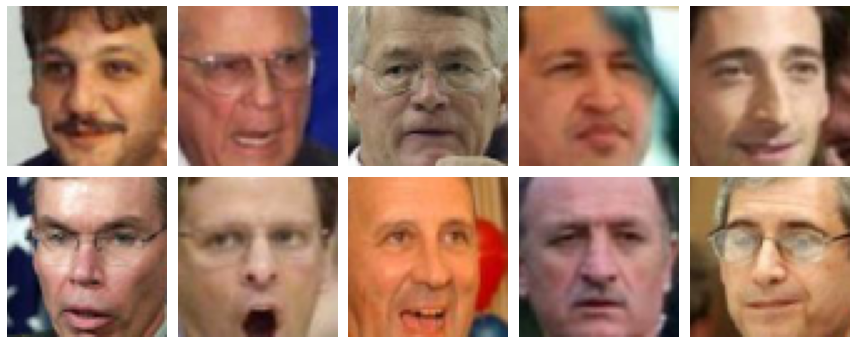

In [ ]:
# let's display 10 images from our face dataset.
fig,ax = plt.subplots(2,5,figsize=(12,5))
axr = ax.ravel()
idxs = np.random.randint(0,len(data),10)
for i,ax in enumerate(axr):
    ax.imshow(data[idxs[i]].permute((1,2,0)))
    ax.axis('off')
plt.tight_layout()

## The architecture of the model.
In this section, we will write and train a simple autoencoder.

<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

The optimal size of the latent vector for training is 512.

In [ ]:
dim_code = 512

Let's write a simple linear autoencoder.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()

        self.dim_code = dim_code
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64,self.dim_code)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.dim_code,3*64*64),
            nn.Unflatten(1,(3,64,64)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

## Training

In [ ]:
# training and validation function
def train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None) -> pd.DataFrame:
    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}
    
    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        # let's take a batch for visualization
        X_viz = next(iter(data_val))
        
        # creating visualization
        fig = plt.figure(figsize=(25,5), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(2, 5)
        gs01 = gs0[1].subgridspec(2, 5)
        for a in range(2):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );
        
        pbar = range(epochs)
    else:
        # if visualization is not available, we will output the loss and score using tqdm
        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:
        
        # we reset the losses and metrics to zero
        avg_train_loss = 0
        avg_val_loss = 0
        
        # train
        model.train()  # we switch the model to train mode
        for X_batch in data_tr:
            # we move the batch to CUDA
            X_batch = X_batch.to(device)
            # we zero the gradients.
            opt.zero_grad()
            # forward
            Y_pred,_ = model(X_batch)
            loss =  loss_fn(Y_pred, X_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # we update the weights


            # we calculate the loss
            avg_train_loss += loss / len(data_tr)

        # val
        model.eval()  # we switch the model to eval mode
        with torch.no_grad():
            for X_val_batch in data_val:
                # we move the batch to CUDA
                X_val_batch = X_val_batch.to(device)
                # forward
                Y_val_pred,_ = model(X_val_batch)
                val_loss =  loss_fn(Y_val_pred, X_val_batch) # forward-pass
                # again, we calculate the loss
                avg_val_loss += val_loss / len(data_val)
         
        # we save the minimum loss and model weights       
        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())
            
        if scheduler:
            scheduler.step()
        
        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())
        
        # we remove everything possible from the GPU,
        # clear the cache to avoid any warnings or errors in Google Colab
        Y_pred.cpu()
        Y_val_pred.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_val_batch.cpu()
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()
        
        # visualization of intermediate results
        model.eval()  # switching the model to eval mode
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz.to(device))[0].detach().cpu()# transferring the prediction to the CPU
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[k].permute((1,2,0)))
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(Y_hat[k].permute((1,2,0)))
                fig.axes[k+5].set_title('Reconstructed')
                fig.axes[k+5].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        # clearing the display to update the image
        display.clear_output(wait=True)
    
    # resetting the model to CPU and clearing the cache
    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


Setting the number of epochs. We tried 40-50, but it wasn't enough, so let's try 60. If we increase it further, we might exceed the free GPU limit of Google Colab.

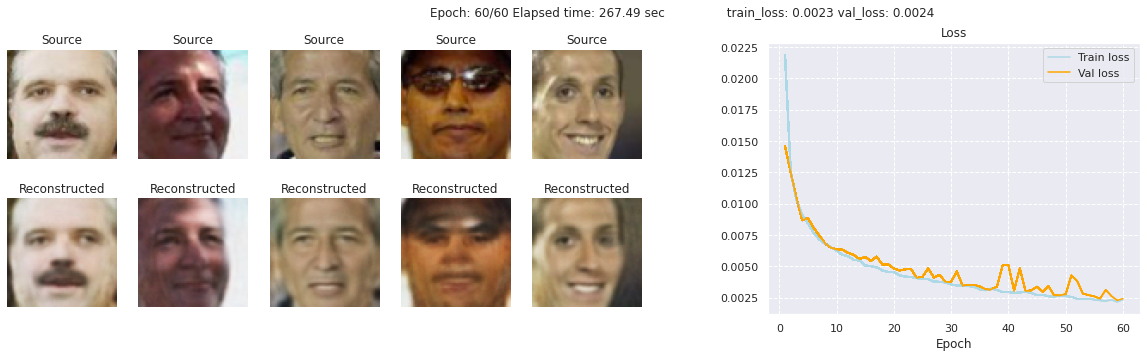

In [ ]:
criterion = nn.MSELoss()
autoencoder = Autoencoder()
autoencoder_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4, amsgrad=True)
autoencoder_history = train(model=autoencoder,\
opt=autoencoder_optimizer, loss_fn=criterion, epochs=60, data_tr=train_loader,\
data_val=val_loader, viz=True, scheduler=None)

Let's see how our trained autoencoder encodes and reconstructs images.

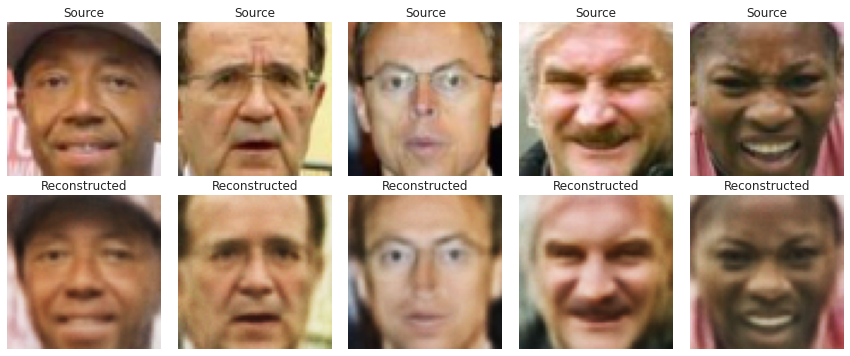

In [ ]:
# function for visualizing the original and reconstructed images
def visualize(model, data, num_imgs):
    idxs = np.random.randint(0,len(val_photos),num_imgs)
    encoded,_ = model(data[idxs])
    fig,ax = plt.subplots(2,num_imgs, figsize=(num_imgs*2+2,5))
    for i in range(len(idxs)):
        ax[0,i].imshow(data[idxs][i].permute((1,2,0)))
        ax[0,i].set_title('Source')
        ax[0,i].axis('off')
        ax[1,i].imshow(encoded[i].detach().permute((1,2,0)))
        ax[1,i].set_title('Reconstructed')
        ax[1,i].axis('off')
    plt.tight_layout();

visualize(autoencoder, val_photos, 5)

Not bad, right? 

## Sampling

Now, let's not just take an image, pass it through the autoencoder, and obtain a reconstruction. Instead, let's try to create something new.
Let's take some vectors generated by us (for example, from a normal distribution) and feed them to the decoder to see the reconstruction result:

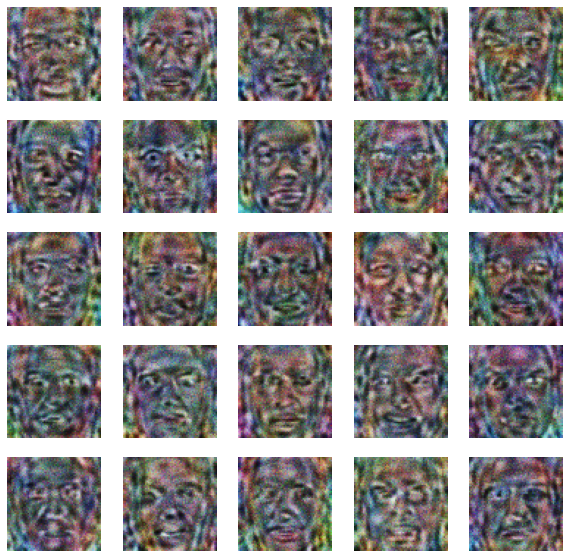

In [ ]:
# let's generate 25 random vectors of size latent_space:
z = np.random.randn(25, dim_code)
output = autoencoder.decoder(torch.FloatTensor(z))
plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
  plt.subplot(5, 5, i + 1)
  generated = output[i].permute(1,2,0).cpu().detach().numpy()
  plt.imshow(generated)
  plt.axis('off')

plt.show()

The outlines of the faces are distinguishable, but the color is not well-represented. We need to carefully specify the vectors for better results.

## Time to make fun!

Let's learn how to add smiles to people's faces =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

The plan is as follows:

* We need to extract the "smile vector": for this, we need to find several (~15) individuals with smiles and an equal number without smiles from the image dataset.
* To find people with smiles, we can use the dataset description file that was downloaded with the dataset. It contains the names of the images and their corresponding attributes (smiles, glasses, etc.).
* Compute the latent vector for all individuals with smiles (pass them through the encoder) and do the same for those without smiles.
* Calculate the smile vector itself by computing the difference between the average latent vector of individuals with smiles and the average latent vector of individuals without smiles.
* Now let's add a smile to a sad person: add the smile vector obtained in step 3 to the latent vector of the sad person, and pass the resulting vector through the decoder. We will obtain the same individual, but now with a smile!

In [ ]:
# function to obtain vectors
def get_vecs(model, data):
    model.to(device)
    model.eval()
    vecs = torch.FloatTensor()
    with torch.no_grad():
        for batch in data:
            batch = batch.to(device)
            lat = model.encoder(batch)
            vecs = torch.cat((vecs,lat.cpu()))
            batch.cpu()
            del batch
        model.cpu()
        torch.cuda.empty_cache()
    return vecs

I've decided to take 100 faces each to obtain a clearer "smile vector".

In [ ]:
# we obtain the indices of smiling, sad, and neutral faces, 100 of each type
smiling_idxs = train_attrs['Smiling'].sort_values(ascending=False)[:100].index.values
grumpy_idxs = train_attrs['Smiling'].sort_values(ascending=True)[:100].index.values
neutral_idxs = train_attrs[(train_attrs['Smiling'] > -.2)\
                           & (train_attrs['Smiling'] < .2)]['Smiling'][:100].index.values

# we create three data loaders for them
smiling_loader =  torch.utils.data.DataLoader(train_photos[smiling_idxs], batch_size=50, shuffle=False)
grumpy_loader =  torch.utils.data.DataLoader(train_photos[grumpy_idxs], batch_size=50, shuffle=False)
neutral_loader =  torch.utils.data.DataLoader(train_photos[neutral_idxs], batch_size=50, shuffle=False)

# we average the vectors of smiling, sad, and neutral faces
smiling_mean = (get_vecs(autoencoder,smiling_loader)).mean(axis=0)
grumpy_mean = (get_vecs(autoencoder,grumpy_loader)).mean(axis=0)
neutral_mean = (get_vecs(autoencoder,neutral_loader)).mean(axis=0)

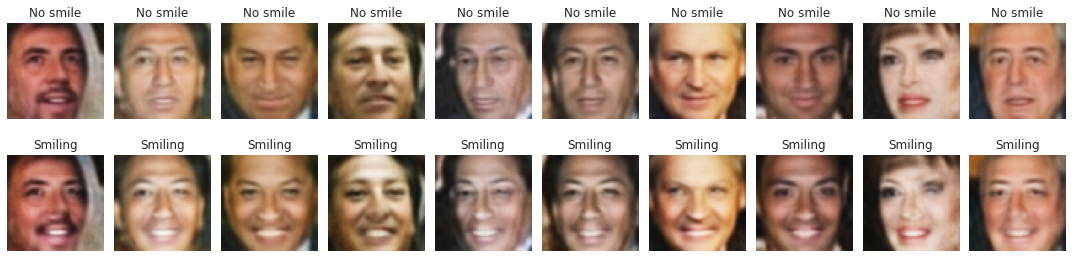

In [ ]:
# we obtain the smile vector by subtracting the averaged vector of sad faces
# from the averaged vector of smiling faces
smile_vector = smiling_mean-grumpy_mean

# we obtain a batch of vectors for neutral faces
neutral_test = autoencoder.encoder(next(iter(neutral_loader)))[26:36]
# we add the smile to the vectors
neutral_plus_smile = neutral_test+smile_vector
# we reconstruct the images
with torch.no_grad():
    source = autoencoder.decoder(neutral_test)
    adjusted = autoencoder.decoder(neutral_plus_smile)
# visualization
fig,ax = plt.subplots(2,10,figsize=(15,4))
axr = ax.ravel()
for i in range(10):
    axr[i].imshow(source[i].permute((1,2,0)))
    axr[i].axis('off')
    axr[i].set_title('No smile')
    axr[i+10].imshow(adjusted[i].permute((1,2,0)))
    axr[i+10].axis('off')
    axr[i+10].set_title('Smiling')
plt.tight_layout();

That's great! Everyone is smiling, just like the locals in Thailand =)

# Variational Autoencoder

Let's dive into training Variational Autoencoders (VAE), an upgraded version of AE. We'll train it on the MNIST dataset, which consists of handwritten digits from 0 to 9.

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## The Model Architecture and Training

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        # the encoder should encode the image into two variables - mu and logsigma
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28*16, out_features=features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=16*28*28),
            nn.ReLU(),
            nn.Unflatten(1, (16, 28, 28)),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=28*28)
        )

    def encode(self, x):
        # the forward pass of the encoder
        x = x.float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] 
        logsigma = x[:, 1, :] 
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # we will sample the latent vector from a normal distribution with parameters mu and sigma
            if self.training:
              std = torch.exp(0.5 * logsigma)
              eps = torch.randn_like(std)
              sample = mu + (eps * std) 
              return sample
        else:
            # During inference, we will return the central vector (mu)
            # instead of a randomly sampled vector from the normal distribution.
            # The output of the autoencoder during inference should be deterministic
            return mu
    
    def decode(self, z):
        # the forward pass of the decoder
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        # Using the encode and decode functions, let's implement the forward pass of the autoencoder
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        return z
        
    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

In [ ]:
features = 16

Let's define the loss and its components for the VAE.
The loss of a VAE consists of two components: KL divergence and log-likelihood.

The overall loss will look like this:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

The formula for KL divergence is:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

For the log-likelihood, we will use the familiar cross-entropy.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    The part of the loss function that captures the "closeness"
    of the latent representations of different individuals
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    The part of the loss function that is responsible for the quality of reconstruction,
    similar to the mean squared error (MSE) in a regular autoencoder
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Training the model:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae
autoencoder = VAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

In [ ]:
# here, 40 epochs are quite sufficient
n_epochs = 40
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          mu, logsigma, reconstruction = autoencoder(batch[0].to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/40 [00:00<?, ?it/s]

Let's see how our trained VAE encodes and reconstructs images.

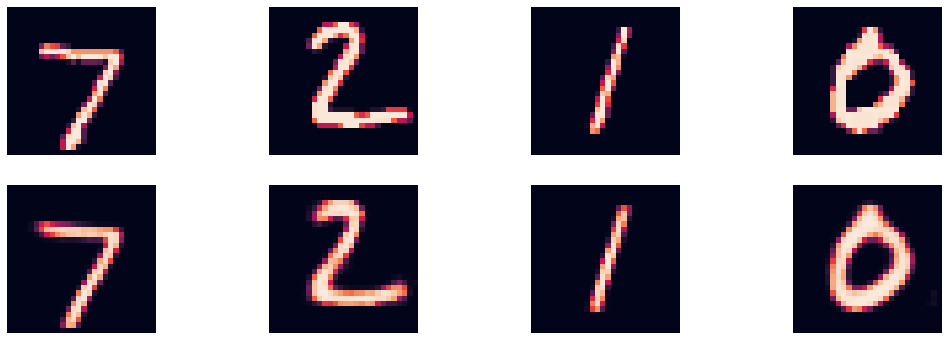

In [ ]:
with torch.no_grad():
    X_batch, _ = next(iter(test_loader))
    mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
    reconstruction = reconstruction.view(-1, 1, 28, 28)
    X_batch = X_batch.numpy()
    reconstruction = reconstruction.cpu().numpy()

    plt.figure(figsize=(18, 6))
    for image_no in range(4):
        plt.subplot(2, 4, image_no + 1)
        plt.axis("off")
        plt.imshow(X_batch[image_no][0])
        
        plt.subplot(2, 4, image_no + 5)
        plt.axis("off")
        plt.imshow(reconstruction[image_no][0])
    plt.show

Let's try to do the same with VAE as we did with the regular autoencoder—provide random vectors from a normal distribution to the decoder of VAE and see what images are generated:

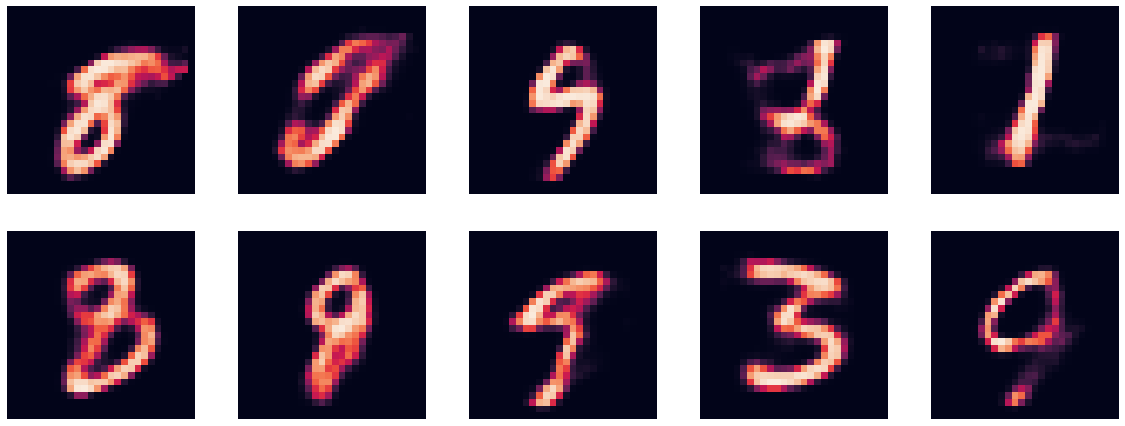

In [ ]:
# let's generate 25 random vectors of size latent_space from a normal distribution
with torch.no_grad():
    z = np.array([np.random.normal(0, 1, features) for i in range(10)])
    z = torch.tensor(z).to(device).float()
    output = autoencoder.decode(z)
    output = output.view(-1, 1, 28, 28)
    output = output.cpu().numpy()
    
    plt.figure(figsize=(20, 20))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.imshow(output[i][0])
    plt.show()

## Latent Representation

Let's visualize how the latent vectors of facial images look in space. We will plot the latent vectors of the images as points in a two-dimensional space. This will allow us to assess how densely the latent vectors of the digit images are distributed in space. Additionally, we will color the points corresponding to images of each digit with a different color.

Here's the plan:
1. Obtain the latent representations of the images in the test dataset.
2. Use `TSNE` (available in `sklearn`) to reduce these representations to a two-dimensional space for visualization.
3. Visualize the obtained two-dimensional representations using `matplotlib.scatter` and color the points with different colors corresponding to images of different digits.

In [ ]:
# list of all labels
labels = [i[1] for i in test_dataset]

latents = torch.FloatTensor()
iterator = iter(test_loader)
for i in range(len(test_loader)):
    images = next(iterator)
    images = images[0]
    autoencoder.eval()
    with torch.no_grad():
        latent = autoencoder.get_latent_vector(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [ ]:
latents_tsne = TSNE(n_components=2).fit_transform(latents)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


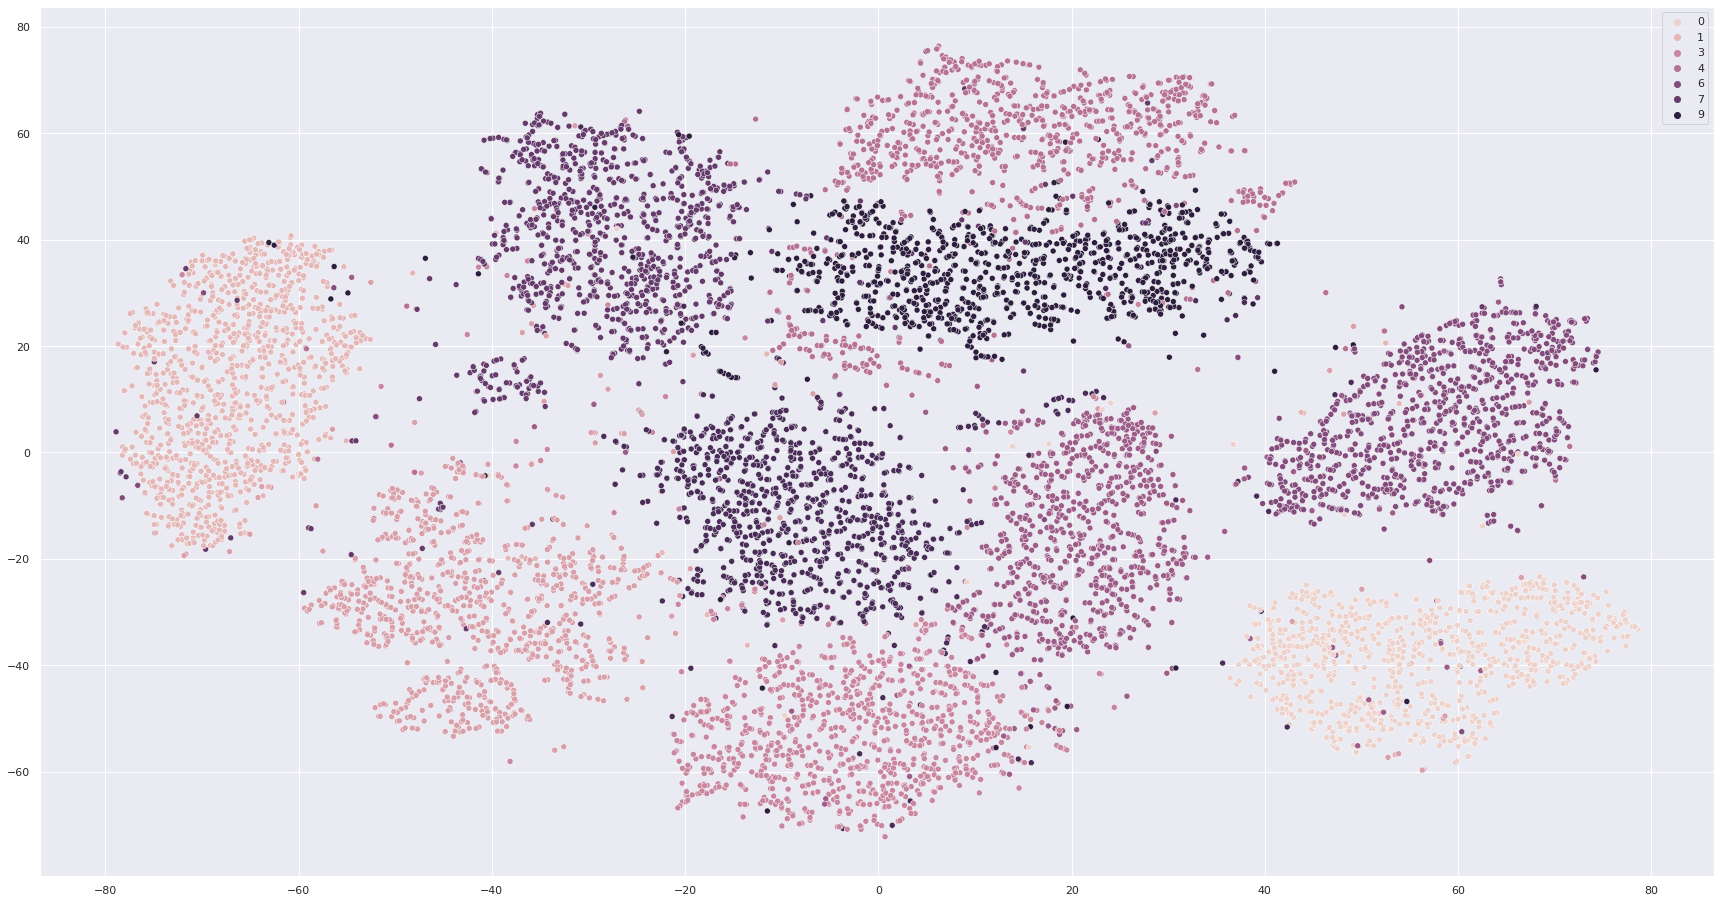

In [ ]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)})
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels)
plt.show()

The distribution is clearly separated into distinct clusters, ranging from -80 to +80 on both axes.
It can be observed that certain digits are more similar to each other, while others are easily distinguishable for the VAE model.

## Conditional VAE


We have already trained a regular Autoencoder (AE) on an image dataset and generated new images using noise generation and the decoder.
Now, let's suppose we have trained an AE on the MNIST dataset and we want to generate new images of numbers using the decoder (similar to how we generated random faces earlier).
However, when we try to generate the number 8 by inputting different noise values, we are unable to generate an eight.

We would like to add a function to our AE that says, "give me a random number from this specific class," where there are ten classes (digits 0 to 9 form ten classes). This type of AE is called a Conditional Autoencoder (CAE), and the name "conditional" speaks for itself.

### Architecture

The architecture of a simple Conditional Variational Autoencoder (VAE) is illustrated in the image below.

Essentially, the only difference from a regular VAE is that we pass additional information about the class of the image along with the image itself in the first layer of both the encoder and decoder.

In other words, the concatenation of the image and class information (for example, a vector of nine zeros and one unit) is fed into the first (input) layer of the encoder. Similarly, the concatenation of the latent vector and class information is fed into the first layer of the decoder.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



Just in case: this is a VAE, which means its latent space still consists of mu and sigma.
Therefore, when generating a new random image, we will need to pass the concatenated latent vector and image class to the decoder.

P.S. It is also possible to pass the image class not only to the first layer but to every layer of the network. In other words, concatenate the output from the previous layer with the class information at each layer.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.label = nn.Embedding(10, features)
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28*16, out_features=features*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features*2, out_features=16*28*28),
            nn.ReLU(),
            nn.Unflatten(1, (16, 28, 28)),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=28*28)
        )

    def encode(self, x, class_num):
        # forward pass of the encoder
        class_num = self.label(class_num)
        x = x.float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] 
        logsigma = x[:, 1, :]        
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # sampling a latent vector from a normal distribution with parameters mu and sigma
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std) 
            return sample
        else:
            # During inference, we return the central vector (mu)
            # instead of a random vector from the normal distribution
            return mu
    
    def decode(self, z, class_num):
        # forward pass of the decoder
        class_num = self.label(class_num)
        z = torch.cat((z, class_num), dim = 1)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)

        return reconstruction

    def forward(self, x, class_num):
        # forward pass of the autoencoder
        mu, logsigma, _ = self.encode(x, class_num)

        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction
    
    def get_latent_vector(self, x, class_num):
        mu, logsigma, class_nums = self.encode(x, class_num)
        z = self.reparameterize(mu, logsigma)
        return z
    
    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

In [ ]:
features = 16

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae
autoencoder = CVAE().to(device)
optimizer =  torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

In [ ]:
# again, 40 epochs are sufficient
n_epochs = 40
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch.to(device),
                                                   y_batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device),
                                                     y_batch.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/40 [00:00<?, ?it/s]

### Sampling

Here we will be sampling from a CVAE. It's more interesting than sampling from a simple AE/VAE because here we can take the same latent vector and ask the CVAE to reconstruct images of different classes from it!

In [ ]:
# we sample from the decoder for the digits of class 5 and 7
z = np.array([np.random.normal(0, 1, features) for i in range(10)])
label_five = np.array([5] * 10)
label_seven = np.array([7] * 10)

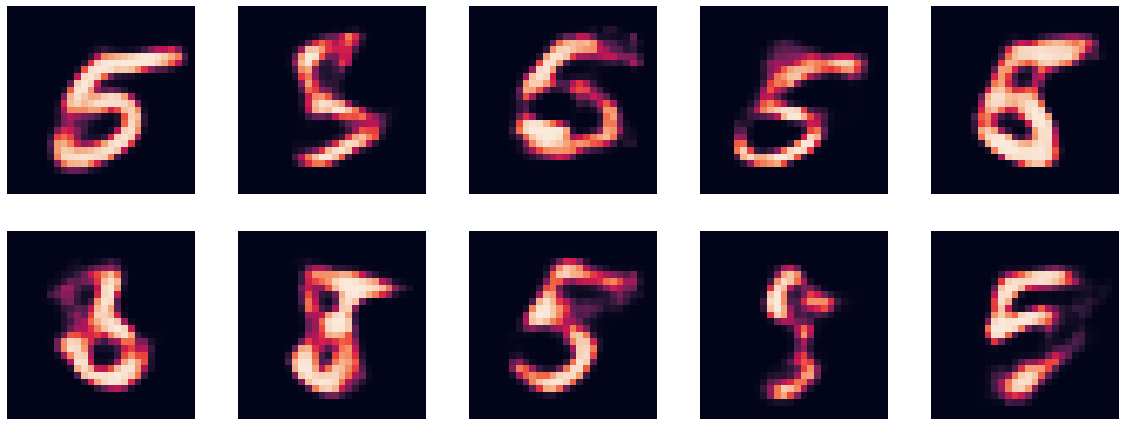

In [ ]:
with torch.no_grad():
    z = torch.tensor(z).to(device).float()
    label_five = torch.tensor(label_five).to(device).int()
    output = autoencoder.decode(z, label_five)
    output = output.view(-1, 1, 28, 28)
    output = output.cpu().numpy()
    
    plt.figure(figsize=(20, 20))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.imshow(output[i][0])
    plt.show()

<ipython-input-212-f40e8711d7ac>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z).to(device).float()


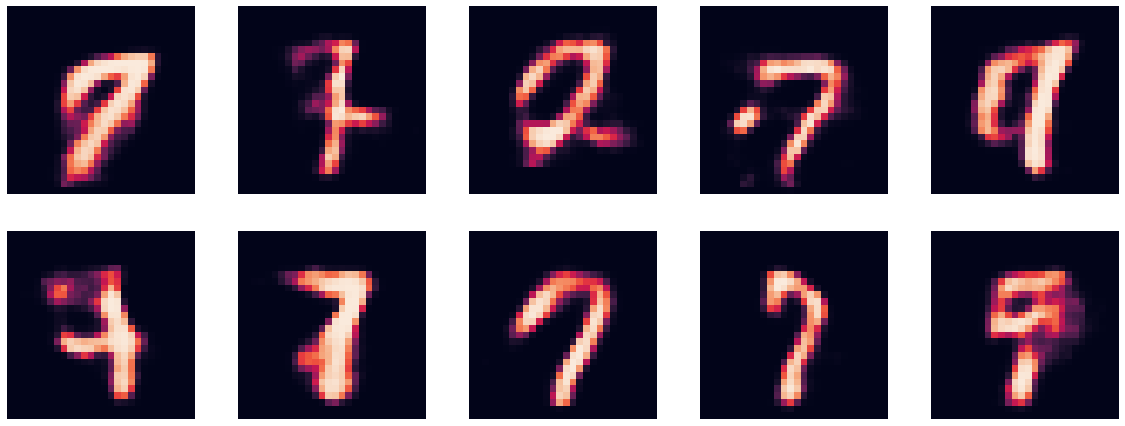

In [ ]:
with torch.no_grad():
    z = torch.tensor(z).to(device).float()
    label_seven = torch.tensor(label_seven).to(device).int()
    output = autoencoder.decode(z, label_seven)
    output = output.view(-1, 1, 28, 28)
    output = output.cpu().numpy()
    
    plt.figure(figsize=(20, 20))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.imshow(output[i][0])
    plt.show()

Not bad!

### Latent Representations

Let's visualize the latent space of images in CVAE and compare it with the image for VAE =)

Once again, we need to color the points based on their class.

In [ ]:
latents = torch.FloatTensor()

for batch in test_loader:
    images, labels = batch
    autoencoder.eval()
    with torch.no_grad():
        latent = autoencoder.get_latent_vector(images.to(device), labels.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [ ]:
latents_tsne = TSNE(n_components=2).fit_transform(latents)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


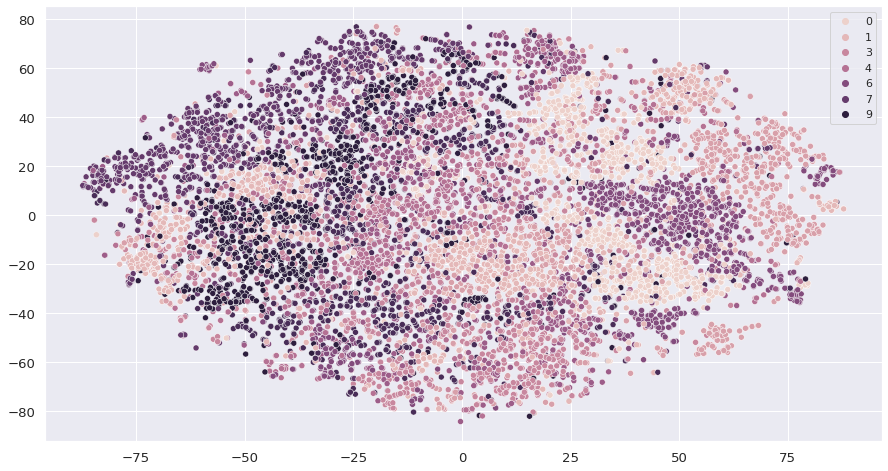

In [ ]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)})
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels)
plt.show()

Now we cannot clearly separate individual classes. However, sampling from such a distribution will be easier.